In [241]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import re
import warnings
warnings.filterwarnings("ignore")

In [242]:
#1.PPI database
PPP_data = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\PPP_Projects_Total.csv")
#2.GDP per capita
GDP_per_capita = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP per Capita.csv")
#3.Tax as GDP
tax_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Tax as GDP.csv")
#4.GDP deflator(inflation rate)
GDP_deflator = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP deflator.csv")
#5.life expectnacy
life_expectnacy = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Life expectnacy.csv")
#6.real effective change
real_effective_change = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Real effect change.csv")
#7.electric consumption
electric_consumption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Electric consumption.csv")
#8.domestic credit to private
domestic_credit_to_private = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Domestic credit to private.csv")
#9.Import as GDP
imports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Imports as GDP.csv")
#10.Export as GDP
exports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Exports as GDP.csv")
#11.Control of corruption
control_of_corruption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Control of corruption.csv")
#12.Government of effectiveness
government_effectiveness = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Government effectiveness.csv", encoding='cp1252')
#13.Political stability
political_stability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Political Stability and Absence of Violence.csv", encoding='cp1252')
#14.regulatory quality
regulatory_quality = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Regulatory quality.csv", encoding='cp1252')
#15.Rule of law
rule_of_law = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Rule of law.csv", encoding='cp1252')
#16.voice and accountability
voice_and_accountability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Voice and accountability.csv", encoding='cp1252')

In [243]:
dataset = [GDP_per_capita, 
           tax_as_GDP, 
           GDP_deflator, 
           life_expectnacy, 
           real_effective_change,
           electric_consumption,
           domestic_credit_to_private, 
           imports_as_GDP, 
           exports_as_GDP, 
           control_of_corruption,
           government_effectiveness, 
           political_stability, 
           regulatory_quality, 
           rule_of_law, 
           voice_and_accountability]

dataset_name = ['GDP_per_capita', 
                'tax_as_GDP', 
                'GDP_deflator', 
                'life_expectnacy', 
                'real_effective_change',
                'electric_consumption', 
                'domestic_credit_to_private', 
                'imports_as_GDP', 
                'exports_as_GDP', 
                'control_of_corruption',
                'government_effectiveness',
                'political_stability', 
                'regulatory_quality', 
                'rule_of_law', 
                'voice_and_accountability']

In [244]:
def process_data(original_data):
    new_data = original_data.copy()
    new_data.replace('..', np.nan, inplace=True)
    new_data.drop(columns=['Series Name', 'Series Code', 'Country Name'], inplace=True)
    new_data.set_index('Country Code', inplace=True)
    new_data.dropna(how='all', inplace=True)
    new_data.columns = [name.split(' ')[0] for name in list(new_data.columns)]
    new_data = new_data.fillna(axis=1, method='bfill')
    new_data = new_data.fillna(axis=1, method='ffill')
    return new_data

for i in np.arange(len(dataset)):
    dataset[i] = process_data(dataset[i])

In [245]:
def meltdata(raw_data, column_name):
    new_data = pd.melt(raw_data.reset_index(), 
                       id_vars=['Country Code'], 
                       var_name=['Year'],
                       value_vars=raw_data.columns,
                       value_name=column_name)
    new_data.Year = new_data.Year.astype('int64', copy=False)
    return new_data

for i,name in zip(np.arange(len(dataset)), dataset_name):
    dataset[i] = meltdata(dataset[i], name).copy()
    dataset[i].rename(columns={'Country Code': 'countrycode', 
                               'Year': 'IY'}, 
                      inplace=True)

for data in dataset:
    PPP_data= PPP_data.merge(data, 
                             left_on=['countrycode', 'IY'], 
                             right_on=['countrycode', 'IY'], 
                             how='left')

In [246]:
data = PPP_data.copy()

In [247]:
float_value = ['GDP_per_capita', 
               'tax_as_GDP', 
               'GDP_deflator', 
               'life_expectnacy', 
               'real_effective_change',
               'electric_consumption', 
               'domestic_credit_to_private', 
               'imports_as_GDP', 
               'exports_as_GDP', 
               'control_of_corruption',
               'government_effectiveness', 
               'political_stability', 
               'regulatory_quality', 
               'rule_of_law', 
               'voice_and_accountability']
nominal_value = ['IDA', 
                 'Region',
                 'type', 
                 'stype', 
                 'sector',
                 'Segment', 
                 'UP', 
                 'PublicDisclosure', 
                 'shareborder', 
                 'PRS', 
                 'Renewables', 
                 'MLS', 
                 'GGC',
                 'lendingtype']
ordinal_value = ['incomelevel']
float_value_2 = ['period', 
                 'realphysicalassets', 
                 'investment_real', 
                 'GDP', 
                 'population', 
                 'CPI2019',
                 'bordercountries', 
                 'private', 
                 'physical', 
                 'period',
                 'investment', 
                 'pcapacity']
data.drop(columns=['bid_crit', 
                   'country', 
                   'regionname',
                   'adminregion',
                   'region',
                   'Description',
                   'adminregionname',
                   'incomelevelname',
                   'income',
                   'lendingtypename',
                   'BS',
                   'PCO',
                   'TIGS'], inplace=True)

data.replace('..', np.nan, inplace=True)
data.replace({'status_n': {'Cancelled': 'fail', 
                           'Distressed': 'fail', 
                           'Active': 'success',
                           'Concluded': 'success'}}, inplace=True)

for float_column in float_value + float_value_2:
    data[float_column] = data[float_column].astype(float)

In [248]:
#split the data
X = data[data.columns[data.columns!='status_n']]
y = data['status_n']
#income value is ordinal value
mapper = {'LIC': 1, 
          'HIC': 2, 
          'LMC': 3, 
          'UMC': 4, 
          np.nan: 0}
X.loc[:, 'incomelevel'] = X.incomelevel.map(mapper)
#convert the FCY to datetime
X.loc[:, 'FCY'] = pd.DatetimeIndex(X.FCY).year
predicted_status = {'success': 0, 
                    'fail': 1}
y = y.map(predicted_status)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y, shuffle=True)

In [249]:
#get the corrlation that larger than a threshold, for numeric data.
def find_correlation(data, threshold):
    correlated_column = defaultdict(list)
    correlation_matrix = data.corr()
    for i, row in correlation_matrix.iterrows():
        for column in correlation_matrix.columns:
            if (abs(row[column]) > threshold) & (abs(row[column]) != 1.0):
                correlated_column[i].append(column)
    return correlated_column

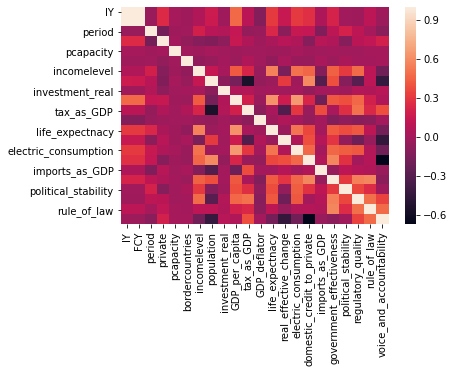

In [10]:
sns.heatmap(X_train.corr().iloc[:28, 0:28])

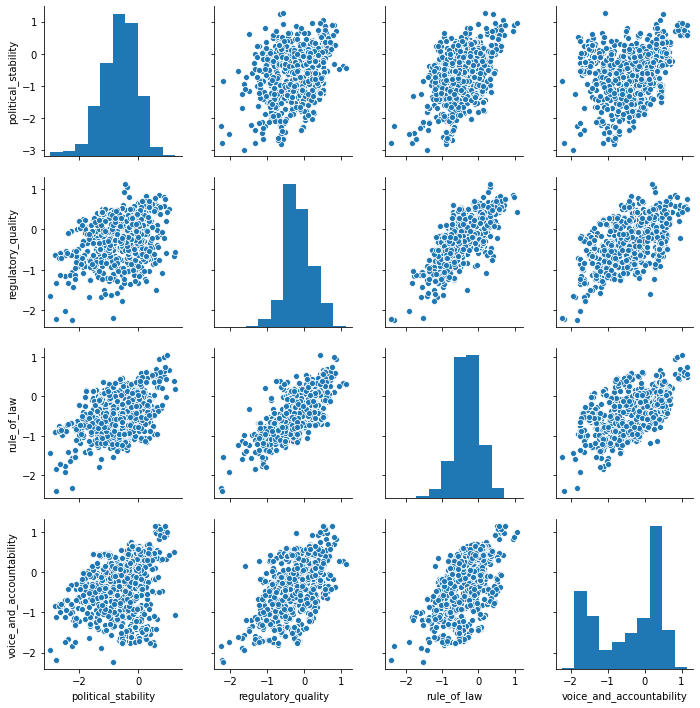

In [132]:
sns.pairplot(X_train.iloc[:, 34:38])

In [250]:
correlated_column = find_correlation(X_train, 0.7)
column_to_be_dropped = ['CPI2019', 
                        'physical', 
                        'investment', 
                        'GDP', 
                        'realphysicalassets',  
                        'exports_as_GDP', 
                        'control_of_corruption', 
                        'IY']
X_train.drop(columns=column_to_be_dropped, inplace=True)
X_test.drop(columns=column_to_be_dropped, inplace=True)

In [251]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5322 entries, 851 to 4383
Data columns (total 37 columns):
Region                        5322 non-null object
IDA                           5322 non-null object
FCY                           5322 non-null int64
type                          5322 non-null object
stype                         5322 non-null object
sector                        5322 non-null object
ssector                       5322 non-null object
Segment                       5322 non-null object
period                        3858 non-null float64
GGC                           4272 non-null object
private                       5121 non-null float64
pcapacity                     4566 non-null float64
PRS                           5318 non-null object
UP                            5322 non-null object
PublicDisclosure              5322 non-null object
bordercountries               5322 non-null float64
shareborder                   5322 non-null object
countrycode          

In [253]:
# one factor
def fill_missing_float_1(train_data, test_data, group_list, column):
    train = train_data.copy()
    test = test_data.copy()
    grouped_period = train.groupby(group_list)[column].mean().to_frame()
    for i, rows in grouped_period.iterrows():
        train_filled = train.loc[train[group_list[0]] == i[0], column]
        test_filled = test.loc[test[group_list[0]] == i[0], column]
        train.loc[train[group_list[0]] == i[0], column] = train_filled.fillna(rows[column])
        test.loc[test[group_list[0]] == i[0], column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test  

# two factors.
def fill_missing_float_2(train_data, test_data, group_list, column):
    train = train_data.copy()
    test = test_data.copy()
    grouped_period = train.groupby(group_list)[column].mean().to_frame()
    for i, rows in grouped_period.iterrows():
        train_filled = train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]), column]
        test_filled = test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]), column]
        train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]), column] = train_filled.fillna(rows[column])
        test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]), column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test        

# two factors.
def fill_missing_float_3(train_data, test_data, group_list, column):
    train = train_data.copy()
    test = test_data.copy()
    grouped_period = train.groupby(group_list)[column].mean().to_frame()
    for i, rows in grouped_period.iterrows():
        train_filled = train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column]
        test_filled = test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column]
        train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column] = train_filled.fillna(rows[column])
        test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test   

#first fillna for training dataset based on country, if some countries are non, then fill with the mode in current column, the same for test dataset.
def fillna_for_nominal_1(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mode_in_train = train.groupby(group_list)[column].agg(pd.Series.mode).to_frame()
    for index, row in mode_in_train.iterrows():
        if type(row[column]) == np.ndarray:
            mode_in_train.loc[index, column] = train[column].mode()[0]
    for i, rows in mode_in_train.iterrows():
            train_filled = train.loc[(train[group_list[0]] == i[0]), column]
            test_filled = test.loc[(test[group_list[0]] == i[0]), column]
            train.loc[(train[group_list[0]] == i[0]), column] = train_filled.fillna(rows[column])
            test.loc[(test[group_list[0]] == i[0]), column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mode()[0])
    test.loc[:, column] = test[column].fillna(train[column].mode()[0])       
    return train, test

#first fillna for training dataset based on country, if some countries are non, then fill with the mode in current column, the same for test dataset.
def fillna_for_nominal_2(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mode_in_train = train.groupby(group_list)[column].agg(pd.Series.mode).to_frame()
    for index, row in mode_in_train.iterrows():
        if type(row[column]) == np.ndarray:
            mode_in_train.loc[index, column] = train[column].mode()[0]
    for i, rows in mode_in_train.iterrows():
            train_filled = train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]), column]
            test_filled = test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]), column]
            train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]), column] = train_filled.fillna(rows[column])
            test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]), column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mode()[0])
    test.loc[:, column] = test[column].fillna(train[column].mode()[0])       
    return train, test

In [254]:
X_train.shape

(5322, 37)

In [255]:
#categorical value.
X_train, X_test = fillna_for_nominal_2(X_train, X_test, ['countrycode', 'ssector'], 'GGC')
X_train, X_test = fillna_for_nominal_2(X_train, X_test, ['countrycode', 'ssector'], 'PRS')
X_train, X_test = fillna_for_nominal_2(X_train, X_test, ['countrycode', 'ssector'], 'lendingtype')
#numeric value from original database.
X_train, X_test = fill_missing_float_2(X_train, X_test, ['stype', 'ssector'], 'period')
X_train, X_test = fill_missing_float_3(X_train, X_test, ['stype', 'ssector', 'countrycode'], 'private')
X_train, X_test = fill_missing_float_2(X_train, X_test, ['countrycode', 'ssector'], 'pcapacity')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'population')
X_train, X_test = fill_missing_float_2(X_train, X_test, ['stype', 'ssector'], 'investment_real')
#numeric value from other databases.
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'GDP_per_capita')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'tax_as_GDP')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'GDP_deflator')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'real_effective_change')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'imports_as_GDP')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'government_effectiveness')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'political_stability')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'regulatory_quality')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'rule_of_law')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'voice_and_accountability')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'life_expectnacy')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'electric_consumption')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'domestic_credit_to_private')

In [256]:
X_train.drop(columns=['countrycode'], inplace=True)
X_test.drop(columns=['countrycode'], inplace=True)

In [257]:
X_train.shape

(5322, 36)

In [258]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [259]:
#to make sure the train and test dataset have the same shape
train_objs_num = len(X_train)
combine_dataset = pd.concat(objs=[X_train, X_test], axis=0)
dataset_preprocessed = pd.get_dummies(combine_dataset, columns=X_train.columns[X_train.dtypes == object], drop_first=True)
X_train = dataset_preprocessed[:train_objs_num]
X_test = dataset_preprocessed[train_objs_num:]

In [260]:
#scaling data
scaler = RobustScaler()
numeric_column = X_train.columns[X_train.dtypes == 'float64']
X_train[numeric_column] = scaler.fit_transform(X_train[numeric_column])
X_test[numeric_column] = scaler.transform(X_test[numeric_column])

In [261]:
X_train.shape

(5322, 100)

In [262]:
#to resample data
train = X_train.join(y_train)

In [263]:
X_bal, y_bal = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(
    X_train,
    y_train)

In [264]:
X_bal = pd.DataFrame(X_bal, columns=X_train.columns)
y_bal = pd.DataFrame(y_bal, columns=['status_n'])
balanced = X_bal.join(y_bal)

bal_corr = balanced.corr()

<BarContainer object of 99 artists>

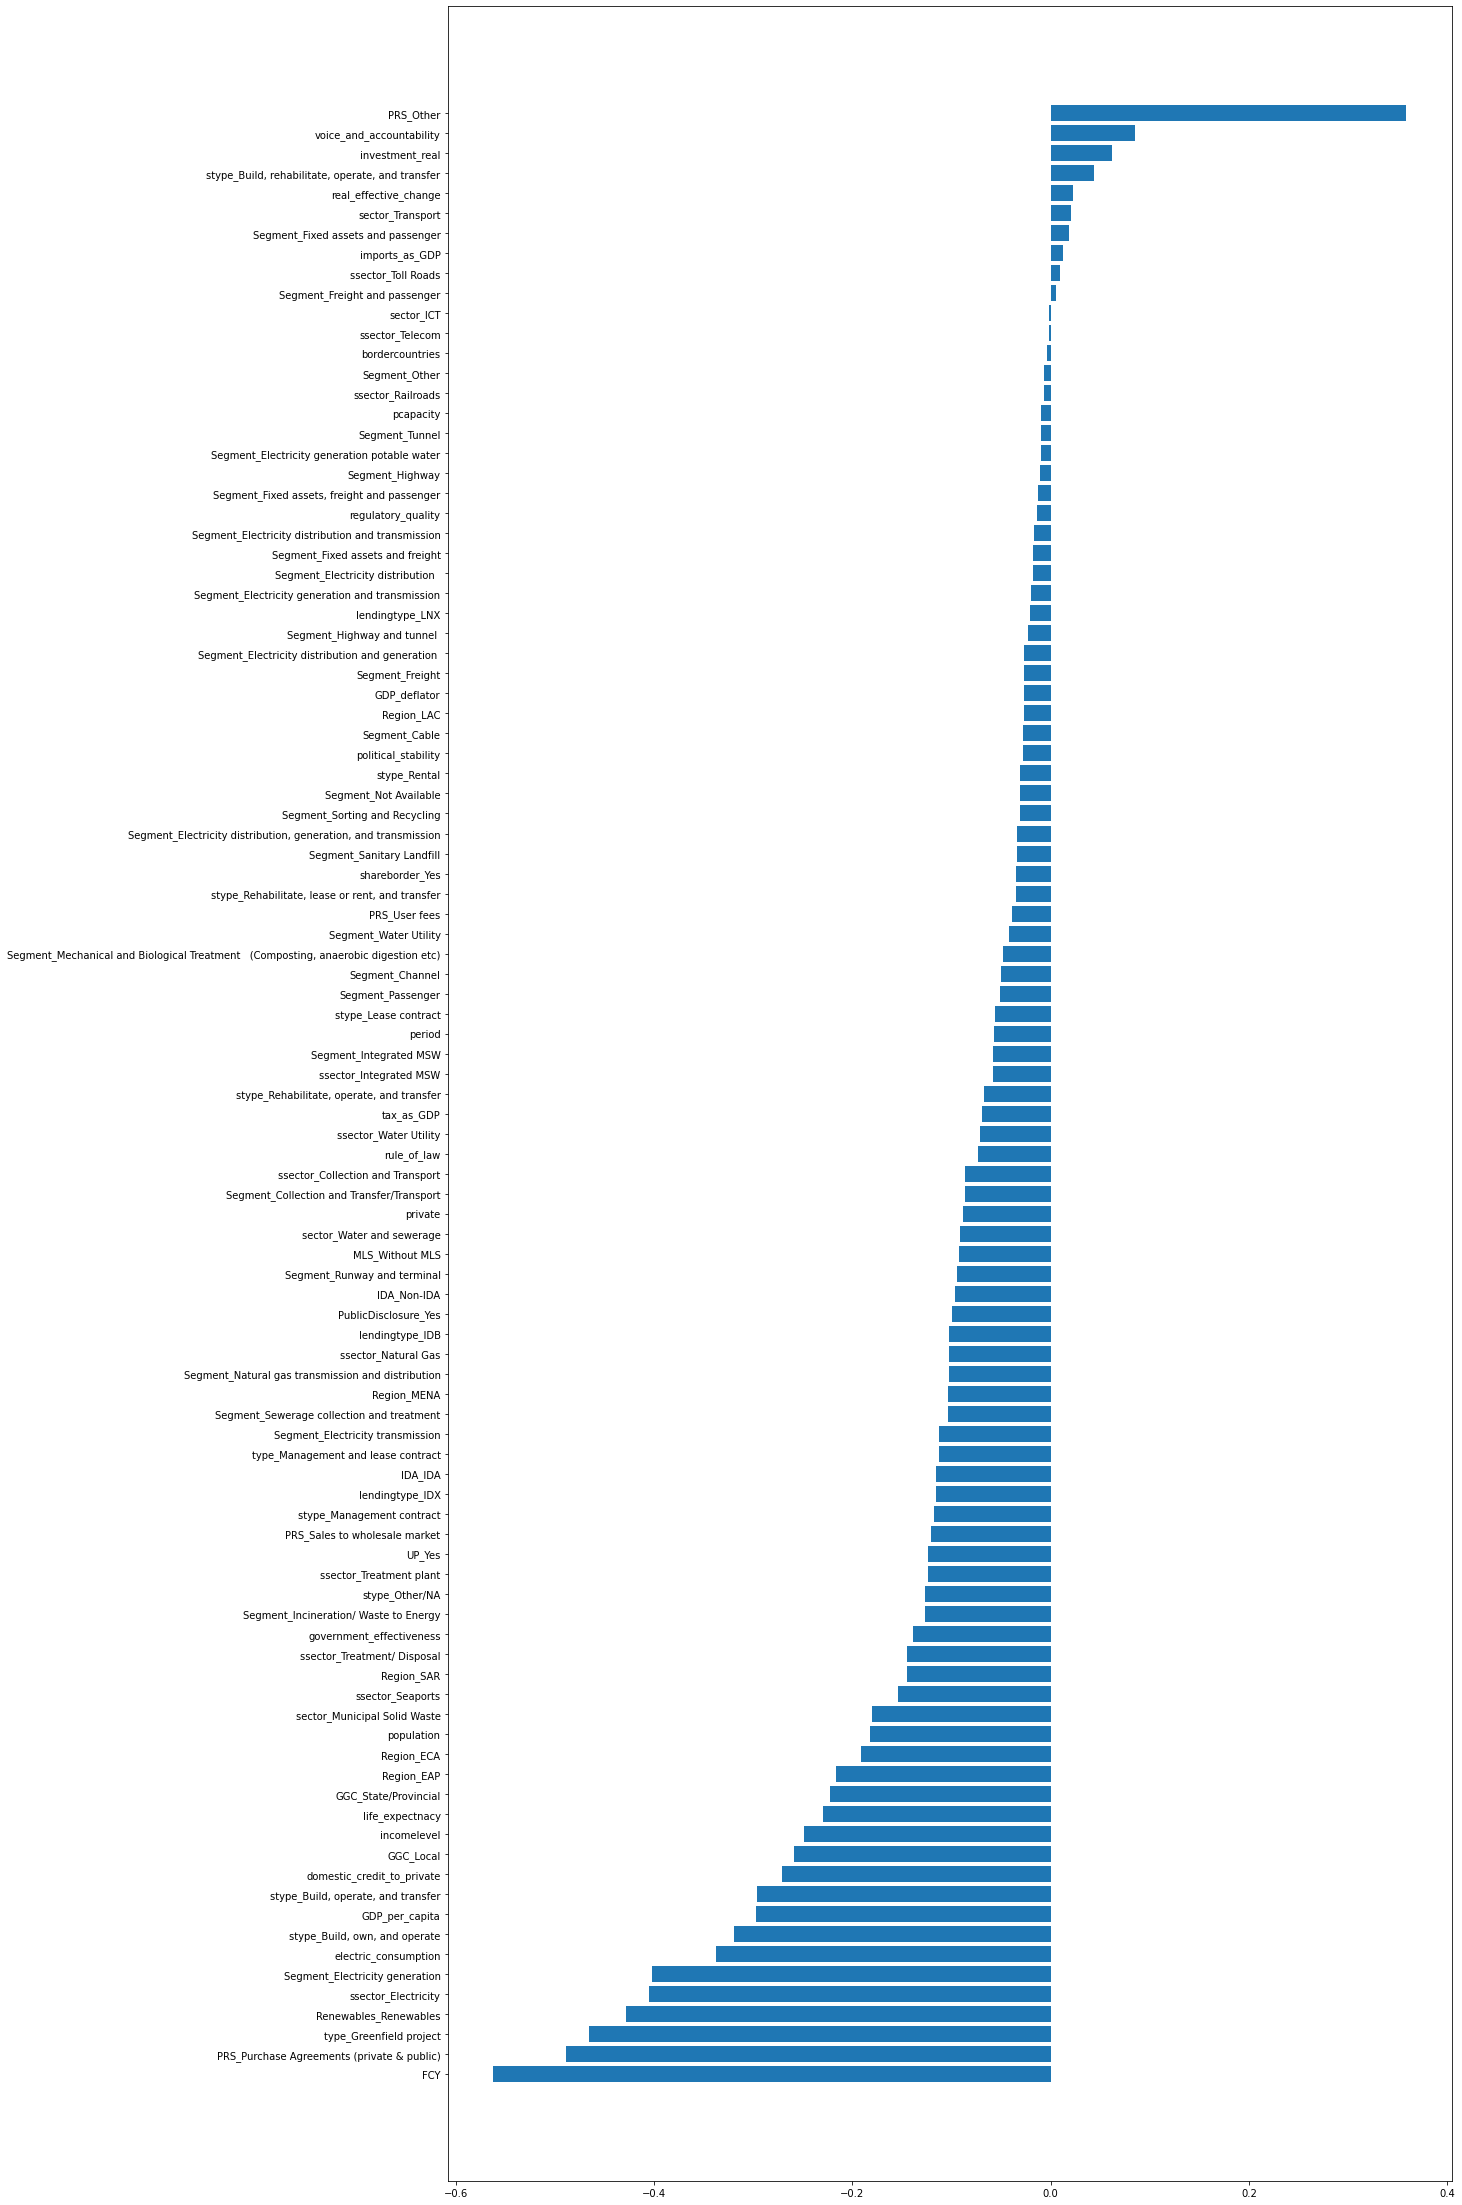

In [83]:
plt.figure(figsize=(18,40))
sorted_correlation =  bal_corr.sort_values(by='status_n', ascending=True)
plt.barh(sorted_correlation.status_n[:-2].index, sorted_correlation.status_n[:-2])

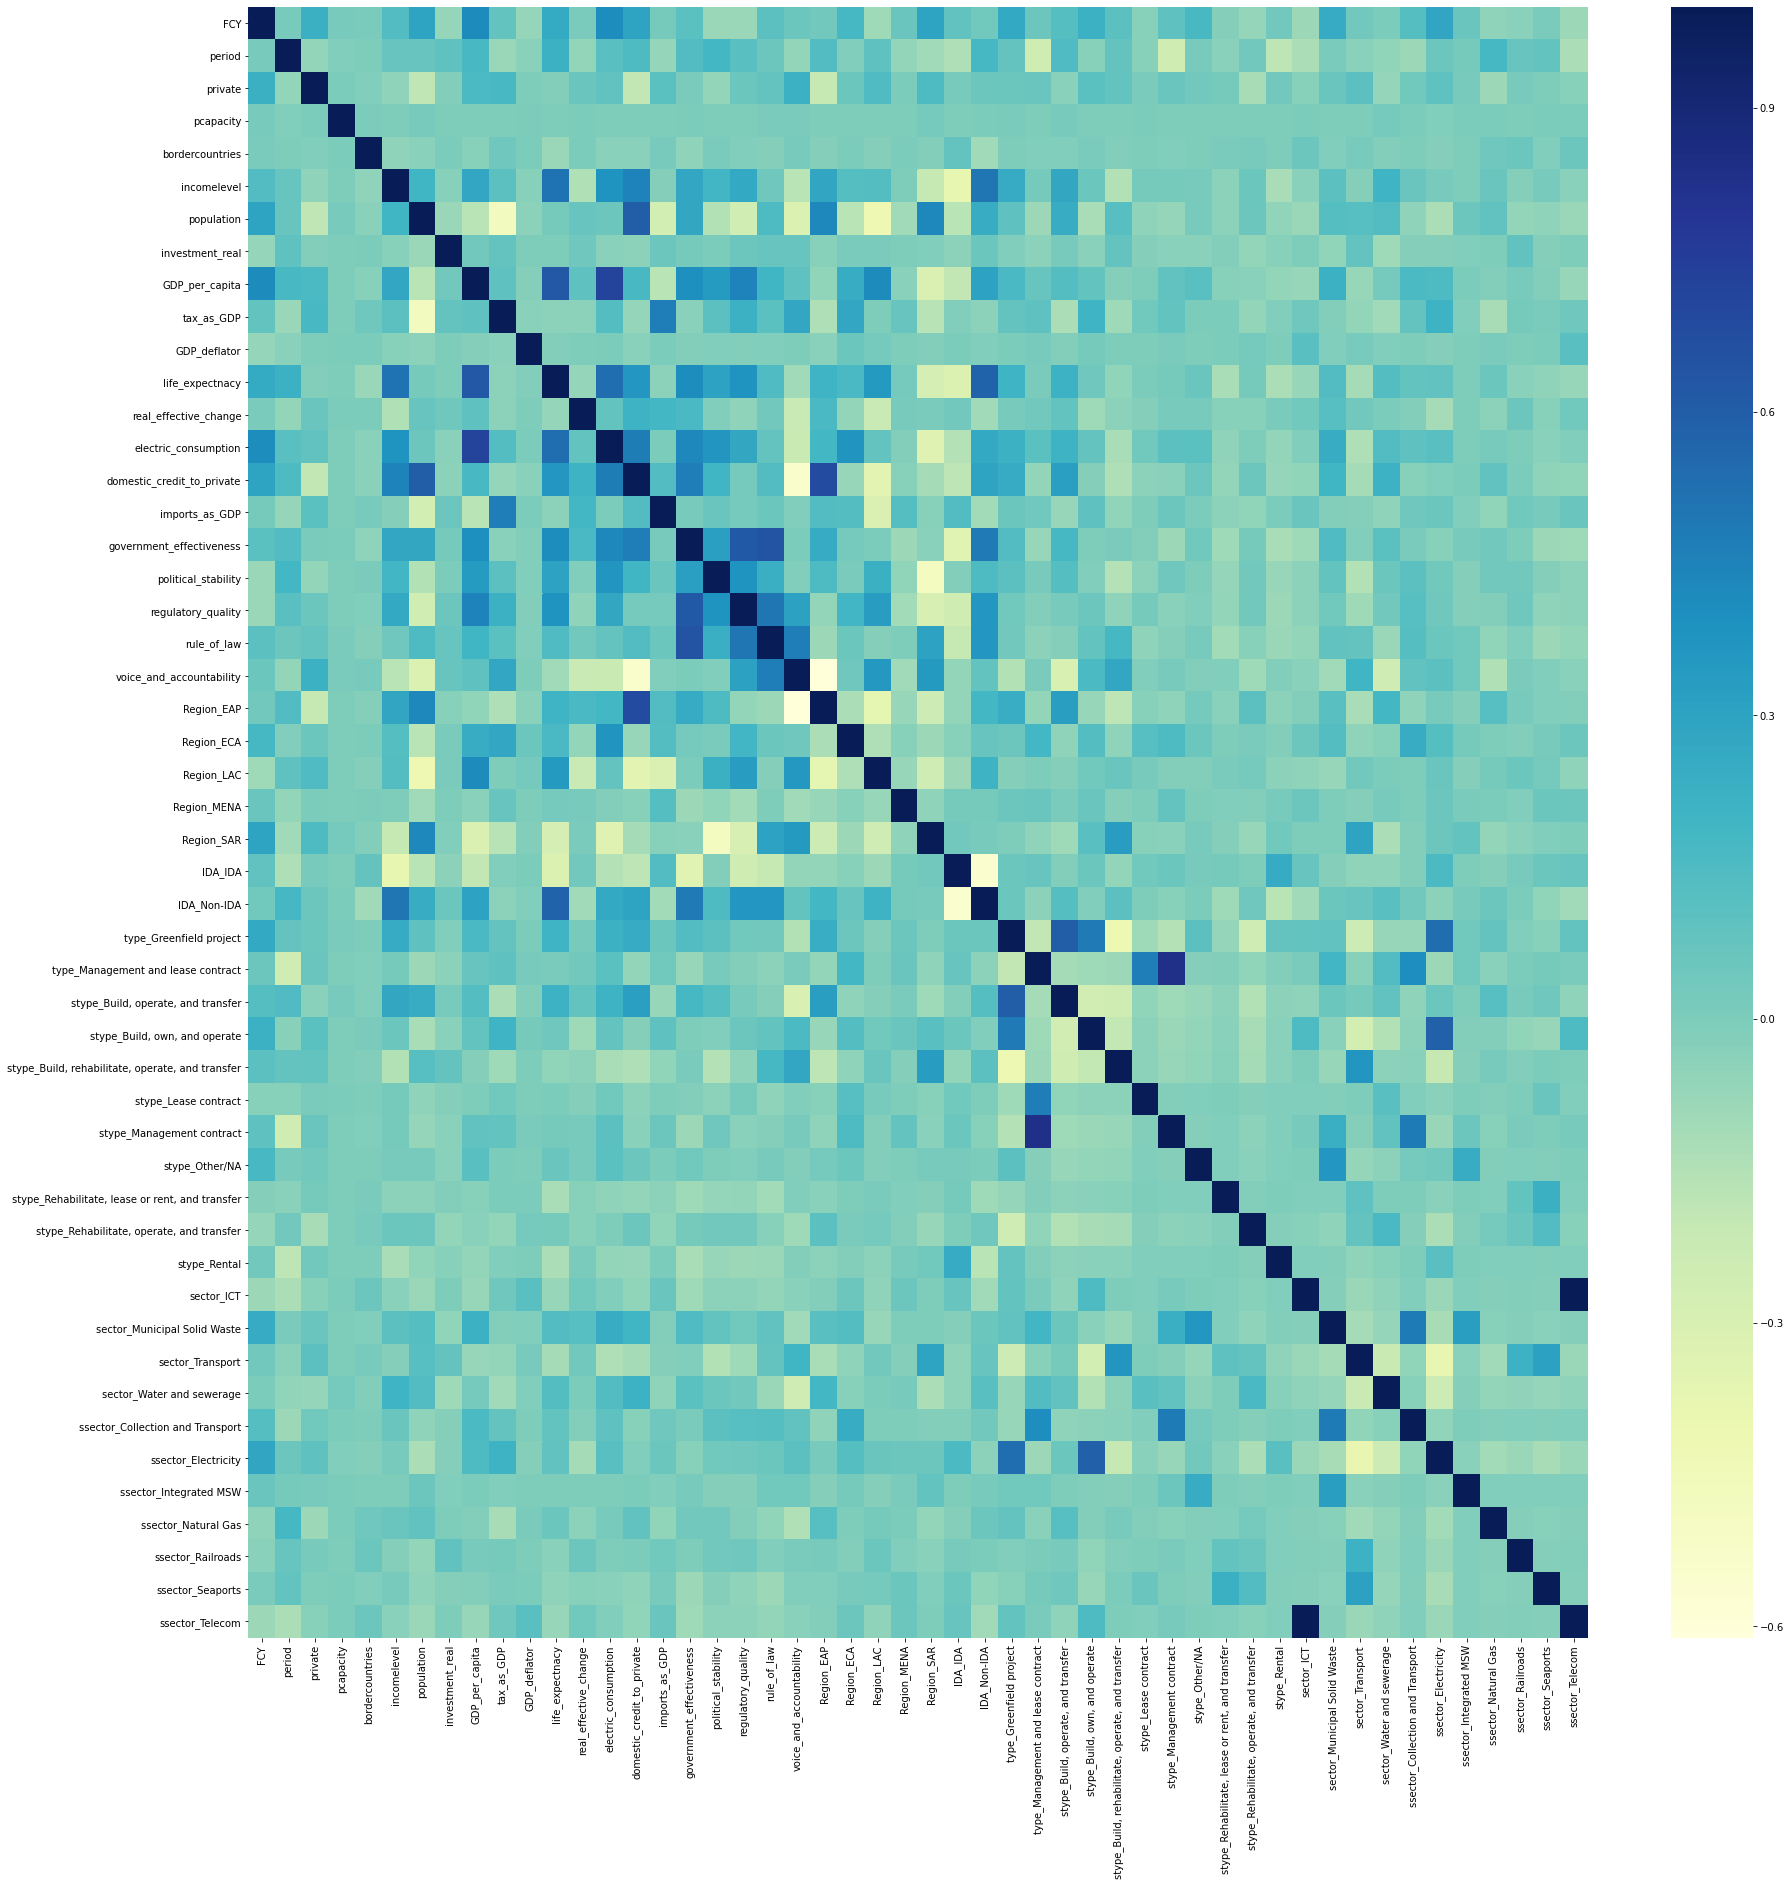

In [86]:
plt.figure(figsize=(30,30))
sns.heatmap(bal_corr.iloc[:50, 0:50], annot_kws={'size':20}, cmap="YlGnBu")

In [265]:
no_outliers = pd.DataFrame(balanced.copy())
cols = bal_corr.status_n.index[:-1]
for col in cols:
    correlation = bal_corr.loc['status_n', col]
    if np.abs(correlation) > 0.1:
        nonfrauds = no_outliers.loc[no_outliers.status_n==0, col]
        frauds = no_outliers.loc[no_outliers.status_n==1, col]
        
        all_values = no_outliers.loc[:,col]
        q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
        iqr = q75 - q25
        cutoff = iqr * 7
        lower, upper = q25 - cutoff, q75 + cutoff
        if correlation > 0: 
            no_outliers.drop(index=nonfrauds[nonfrauds>upper].index,inplace=True)
            no_outliers.drop(index=frauds[frauds<lower].index,inplace=True)
        elif correlation < 0: 
            no_outliers.drop(index=nonfrauds[nonfrauds<lower].index,inplace=True)
            no_outliers.drop(index=frauds[frauds>upper].index,inplace=True)

In [266]:
balanced.shape

(10183, 101)

In [267]:
feat_sel =pd.DataFrame(no_outliers.copy())
new_corr = feat_sel.corr()
for col in new_corr.status_n.index[:-1]:
    if np.abs(new_corr.loc['status_n', col]) < 0.1:
        feat_sel.drop(columns=col, inplace=True)

In [268]:
X_train = feat_sel.drop('status_n', 1)
y_train = feat_sel.status_n

cols = X_train.columns
X_test = X_test[cols]

#X_train, y_train = RandomUnderSampler(sampling_strategy={1:5000,0:5000}).fit_resample(X_train,y_train)


In [269]:
X_train, y_train = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(
    X_train,
    y_train)

In [270]:
y_train.sum()/len(y_train)

0.5004394960445356

In [271]:
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return (fpr, tpr, thresholds)

def plot_recall_precision(y_true, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    plt.title('Recall-Precision')
    plt.plot(recall, precision, 'k')
    no_skill = y_true.sum()/len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.legend(loc = 'lower right')
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    return (precision, recall, thresholds)

def plot_cm(labels, predictions, p=0.1):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [272]:
#clf and upsample
clf = RandomForestClassifier(random_state=1)
param_grid = {'n_estimators': [int(x) for x in np.linspace(700, 2000, 30)],
              'max_features': ['auto', 'sqrt'], 
              'max_depth': [int(x) for x in np.linspace(10, 80, 20)],
              'min_samples_split': [int(x) for x in np.linspace(2, 30, 10)],
              'min_samples_leaf': [int(x) for x in np.linspace(2, 30, 10)],
              'bootstrap': [True, False]}
clf_random_grid = RandomizedSearchCV(clf, 
                                     param_grid, 
                                     refit=True, 
                                     verbose=-1, 
                                     cv=3,
                                     n_jobs=-1)
clf_random_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 13, 17, 21, 24, 28,
                                                      32, 35, 39, 43, 46, 50,
                                                      54, 57, 61, 65, 68, 72,
                                                      76, 80],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 8, 11, 14,
                                                             17, 20, 23, 26,
                                                             30],
                                        'min_samples_split': [2, 5, 8, 11, 14,
                                                              17, 20, 23, 26,
                                                              30],
           

In [274]:
clf_random_grid.best_params_

{'n_estimators': 1731,
 'min_samples_split': 2,
 'min_samples_leaf': 20,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [795]:
param_grid = {'n_estimators': [1370, 1372, 710],
              'max_features': ['sqrt'], 
              'max_depth': [55, 56, 57],
              'min_samples_split': [21, 22, 23],
              'min_samples_leaf': [2],
              'bootstrap': [False]}
clf_grid = GridSearchCV(clf, 
                        param_grid, 
                        refit=True, 
                        verbose=-1, 
                        cv=3,
                        n_jobs=-1)
clf_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  3.2min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [55, 56, 57],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2],
                         'min_samples_split': [21, 22, 23],
                         'n_estimators': [690, 700, 710]},
             verbose=-1)

In [799]:
clf_grid.best_params_

{'bootstrap': False,
 'max_depth': 55,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 22,
 'n_estimators': 690}

In [275]:
#clf and upsample
pred_clf_upsample = cross_val_predict(clf_random_grid.best_estimator_,
                                      X_test,
                                      y_test,                                      
                                      method='predict_proba',
                                      cv=5)

(array([0.        , 0.        , 0.00175953, 0.00175953, 0.00410557,
        0.00410557, 0.00762463, 0.00762463, 0.00879765, 0.00997067,
        0.0111437 , 0.0111437 , 0.01290323, 0.01290323, 0.01348974,
        0.01348974, 0.01466276, 0.01466276, 0.01524927, 0.01524927,
        0.01642229, 0.01642229, 0.01759531, 0.01759531, 0.01876833,
        0.01876833, 0.01994135, 0.01994135, 0.028739  , 0.028739  ,
        0.03519062, 0.03519062, 0.03695015, 0.03695015, 0.04750733,
        0.04750733, 0.04985337, 0.04985337, 0.0516129 , 0.0516129 ,
        0.05571848, 0.05571848, 0.0568915 , 0.0568915 , 0.05865103,
        0.05865103, 0.06686217, 0.06686217, 0.06979472, 0.07096774,
        0.07331378, 0.07331378, 0.07507331, 0.07507331, 0.08621701,
        0.08739003, 0.09032258, 0.09032258, 0.09794721, 0.09794721,
        0.1085044 , 0.10967742, 0.11495601, 0.11495601, 0.11671554,
        0.11671554, 0.11788856, 0.11964809, 0.12082111, 0.12082111,
        0.12903226, 0.12903226, 0.13020528, 0.13

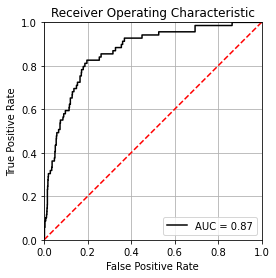

In [276]:
plot_roc(y_test, pred_clf_upsample[:,1])

No handles with labels found to put in legend.


(array([0.04468912, 0.04409857, 0.04412719, ..., 0.5       , 1.        ,
        1.        ]),
 array([1.        , 0.98550725, 0.98550725, ..., 0.01449275, 0.01449275,
        0.        ]),
 array([0.00158088, 0.00158445, 0.0016148 , ..., 0.33386196, 0.34136067,
        0.34216493]))

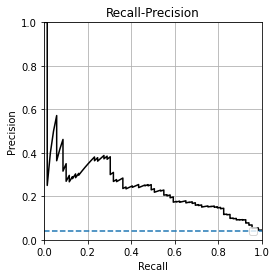

In [277]:
plot_recall_precision(y_test, pred_clf_upsample[:,1])

In [278]:
confusion_matrix(y_test, pred_clf_upsample[:, 1] > 0.1)

array([[1543,  162],
       [  29,   40]], dtype=int64)

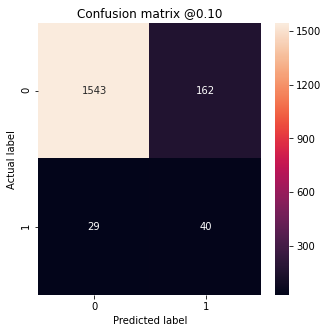

In [279]:
plot_cm(y_test, pred_clf_upsample[:, 1])

In [280]:
#feature importance
fi = pd.DataFrame({'feature': list(X_bal.columns),
                   'importance': clf_random_grid.best_estimator_.feature_importances_}).\
                    sort_values('importance', ascending = False)

ValueError: arrays must all be same length

In [281]:
fi.head(40)

NameError: name 'fi' is not defined

In [282]:
X_train_lgb = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_lgb = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_train_lgb = y_train.copy()
y_test_lgb = y_test.copy()
clf_lgb = lgb.LGBMClassifier(random_state=1)

param_grid = {'learning_rate': [x for x in np.linspace(0.005, 0.01, 3)],
              'n_estimators': [int(x) for x in np.linspace(700, 2000, 30)],
              'num_leaves': [int(x) for x in np.linspace(10, 40, 30)],
              'boosting_type' : ['gbdt'],
              'objective' : ['binary'],
              'random_state' : [501], 
              'colsample_bytree' : [x for x in np.linspace(0.3, 1.0, 20)],
              'subsample' : [x for x in np.linspace(0.3, 1.0, 20)]}
lgb_random_grid = RandomizedSearchCV(clf_lgb, 
                                     param_grid, 
                                     refit=True, 
                                     verbose=-1, 
                                     cv=2,
                                     n_jobs=-1)
lgb_random_grid.fit(X_train_lgb, y_train_lgb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.4s finished


RandomizedSearchCV(cv=2, estimator=LGBMClassifier(random_state=1), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.3,
                                                             0.3368421052631579,
                                                             0.3736842105263158,
                                                             0.41052631578947363,
                                                             0.4473684210526315,
                                                             0.4842105263157894,
                                                             0.5210526315789473,
                                                             0.5578947368421052,
                                                             0.5947368421052631,
                                                             0.631578947368421,
                                                            

In [283]:
lgb_random_grid.best_params_

{'subsample': 0.7789473684210526,
 'random_state': 501,
 'objective': 'binary',
 'num_leaves': 29,
 'n_estimators': 1417,
 'learning_rate': 0.0075,
 'colsample_bytree': 0.3736842105263158,
 'boosting_type': 'gbdt'}

In [284]:
pred_lgb_upsample = cross_val_predict(lgb_random_grid.best_estimator_,
                                      X_test_lgb,
                                      y_test_lgb,
                                      method='predict_proba',
                                      cv=5)

(array([0.00000000e+00, 5.86510264e-04, 5.86510264e-04, 4.10557185e-03,
        4.10557185e-03, 5.27859238e-03, 5.27859238e-03, 5.86510264e-03,
        5.86510264e-03, 6.45161290e-03, 6.45161290e-03, 7.03812317e-03,
        7.03812317e-03, 8.21114370e-03, 8.21114370e-03, 9.38416422e-03,
        1.05571848e-02, 1.23167155e-02, 1.34897361e-02, 1.34897361e-02,
        1.87683284e-02, 1.87683284e-02, 2.22873900e-02, 2.22873900e-02,
        2.28739003e-02, 2.28739003e-02, 2.34604106e-02, 2.34604106e-02,
        2.63929619e-02, 2.63929619e-02, 2.93255132e-02, 2.93255132e-02,
        3.10850440e-02, 3.10850440e-02, 3.22580645e-02, 3.22580645e-02,
        3.40175953e-02, 3.40175953e-02, 3.63636364e-02, 3.63636364e-02,
        3.98826979e-02, 4.16422287e-02, 4.16422287e-02, 4.22287390e-02,
        4.22287390e-02, 4.57478006e-02, 4.69208211e-02, 4.69208211e-02,
        5.45454545e-02, 5.45454545e-02, 5.86510264e-02, 5.86510264e-02,
        6.39296188e-02, 6.39296188e-02, 6.92082111e-02, 6.920821

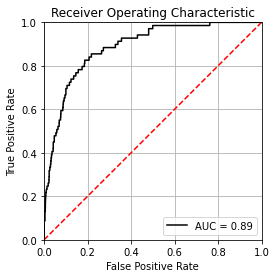

In [285]:
plot_roc(y_test, pred_lgb_upsample[:,1])

No handles with labels found to put in legend.


(array([0.05040175, 0.04974396, 0.04978038, ..., 0.5       , 0.        ,
        1.        ]),
 array([1.        , 0.98550725, 0.98550725, ..., 0.01449275, 0.        ,
        0.        ]),
 array([1.08003432e-05, 1.08573051e-05, 1.08575322e-05, ...,
        9.67116993e-01, 9.68413183e-01, 9.88890202e-01]))

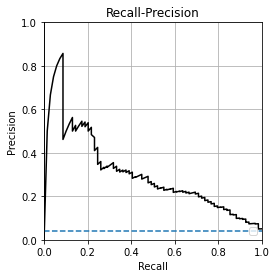

In [286]:
plot_recall_precision(y_test_lgb, pred_lgb_upsample[:,1])

In [290]:
confusion_matrix(y_test, pred_lgb_upsample[:, 1] > 0.1)

array([[1652,   53],
       [  44,   25]], dtype=int64)

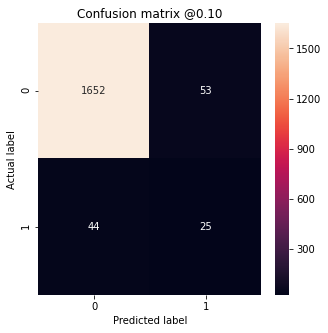

In [288]:
plot_cm(y_test_lgb, pred_lgb_upsample[:, 1])